<center>
<hr>
<h1> Gridness score</h1>

<hr>
</center>

In [1]:
import numpy as np
from scores import GridScorer, circle_mask
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import scipy.signal

# Load saved data and initialize scorer class

Args:

nbins: Number of bins per dimension in the ratemap.

coords_range: Environment coordinates range.

mask_parameters: parameters for the masks that analyze the angular
        autocorrelation of the 2D autocorrelation.

In [2]:
activations = np.load('../data/activations4096.npy')
Ng = 4096
rate_map = activations.reshape(Ng, -1)

box_width, box_height = 2.2, 2.2
res = 20
coord_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())
corr_angles = [30, 45, 60, 90, 120, 135, 150]

scorer = GridScorer(res, coord_range, masks_parameters)

# Calculate spatial autocorrelation


\
$$
r\left(\tau_{x}, \tau_{y}\right)=\frac{n \sum \lambda(x, y) \lambda\left(x-\tau_{x}, y-\tau_{y}\right)-\sum \lambda(x, y) \sum \lambda\left(x-\tau_{x}, y-\tau_{y}\right)}{\sqrt{n \sum \lambda(x, y)^{2}-\left(\sum \lambda(x, y)\right)^{2}} \sqrt{n \sum \lambda\left(x-\tau_{x}, y-\tau_{y}\right)^{2}-\left(\sum \lambda\left(x-\tau_{x}, y-\tau_{y}\right)\right)^{2}}}
$$


\
where $\lambda(x,y)$ is the avarage rate at pos (x,y)

$r\left(\tau_{x}, \tau_{y}\right)$ is the autocorrelation between the fields with spatial lags of $\tau_{x}$ and $\tau_{y}$

and the summation is over all n pixel in $\lambda(x,y)$

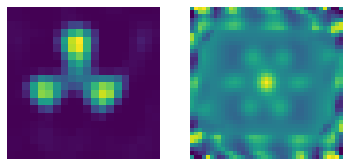

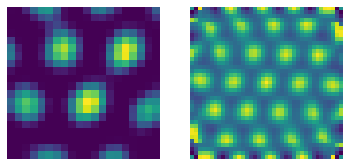

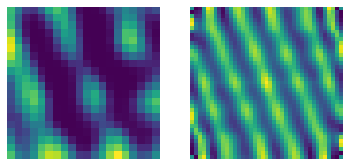

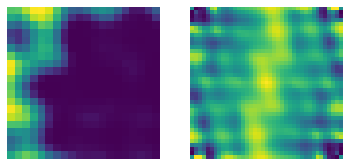

In [7]:
l = [0,8,1252,3894]
for i in l:
    plt.figure()
    plt.subplot(121)
    plt.imshow(activations[i])
    plt.axis('off')
    sac = scorer.calculate_sac(activations[i])
    plt.subplot(122)
    plt.imshow(sac)
    plt.axis('off')
    plt.show()

# Rotate sac

The degree of spatial periodicity (gridness) is determined for each cell by rotating the autocorrelation map in steps of increasing angles computing the correlation between the rotated map and the original.

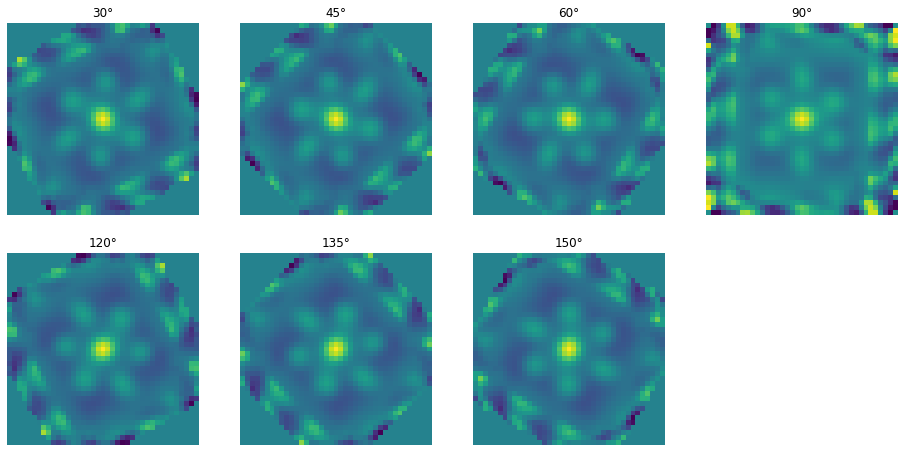

In [8]:
idx = 0
sac = scorer.calculate_sac(activations[idx])
rotated_sacs = scorer.rotated_sacs(sac, scorer._corr_angles)

i = 1
plt.figure(figsize=(16,12))
for s in rotated_sacs:
    plt.subplot(3,4,i)
    plt.imshow(s)
    plt.axis('off')
    plt.title(str(scorer._corr_angles[i-1]) + '°')
    i+=1

# Apply masks

The correlation was confined to the area defined by a circle around the outermost peak of the six peaks closest to the centre of the autocorrelation map; the central peak is not included.
In order to do so, different mask of growing radius are applied to the sac and its rotated version.

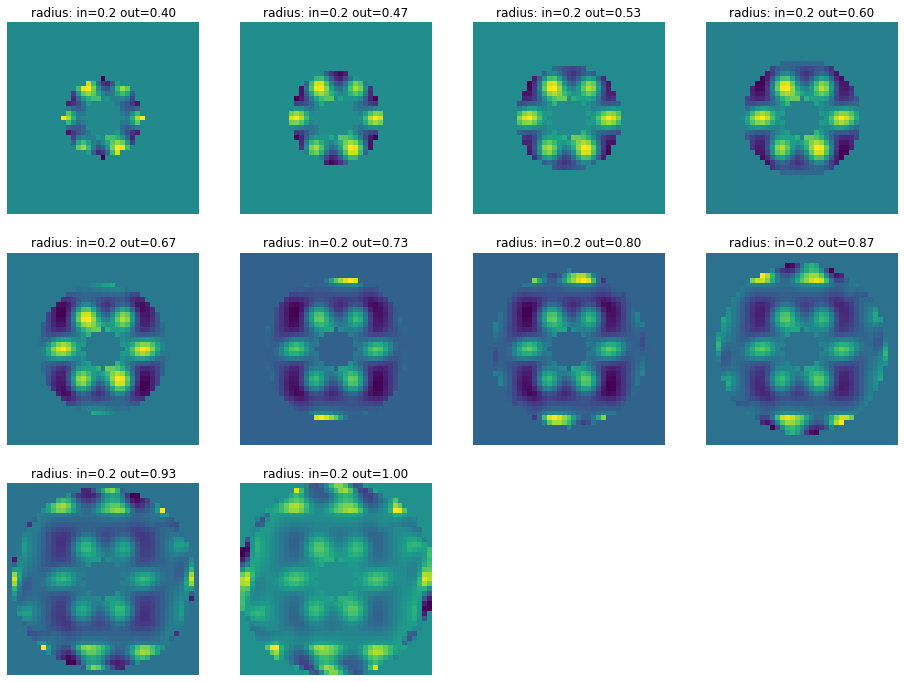

In [9]:
plt.figure(figsize=(16,12))
i=1

for mask, mask_par in scorer._masks:
    masked_sac = sac * mask
    ring_area = np.sum(mask)
    # Calculate dc on the ring area
    masked_sac_mean = np.sum(masked_sac) / ring_area
    # Center the sac values inside the ring
    masked_sac_centered = (masked_sac - masked_sac_mean) * mask
    plt.subplot(3,4,i)
    plt.imshow(masked_sac_centered)
    plt.title('radius: in='+str(mask_par[0])+' out='+str("%0.2f"%mask_par[1]))
    plt.axis('off')
    i+=1

# Score

The 'gridness' score is expressed as the difference between the correlation at 60° and 120° (where the peaks are expected) and the correlation at 30°, 90° and 150° (where the minimum are expected). This is for the triangular grid.
We can also define a score for the square grid as the difference between correlation at 90° and correlation at 45° and 135°.



$$ score60 = \frac{corr(60°)+corr(120°)}{2}-\frac{corr(30°)+corr(90°)+corr(150°)}{3} $$



$$ score90 = corr(90°)-\frac{corr(45°)+corr(135°)}{2} $$


The scores values are calculated for every masks, and by default the maximum of the two values is returned


In [10]:
scores = [
        scorer.get_grid_scores_for_mask(sac, rotated_sacs, mask)
        for mask, mask_params in scorer._masks
        ]
scores_60, scores_90, variances = map(np.asarray, zip(*scores))
max_60_ind = np.argmax(scores_60)
max_90_ind = np.argmax(scores_90)

In [11]:
print('Score60 = '+ str(scores_60[max_60_ind]))
print('Score90 = '+ str(scores_90[max_90_ind]))

Score60 = 1.571286983151635
Score90 = 0.13471947701229342


In [12]:
score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = scorer.get_scores(activations[idx])
score_60, score_90

(1.571286983151635, 0.13471947701229342)